<div style="background-color:rgba(78, 188, 130, 0.05); text-align:center; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(78, 188, 130, 1.0); color: #000000;">

<img src="figs/qr_logo.png" width="700"/>

<h1><strong>Quantum Summer School</strong></h1>

<h2><strong>Episode 6</strong></h2>

<h3><strong>"Toy" Algorithms</strong></h3>

</div>

*In this session, we’ll explore three toy algorithms that highlight the power of quantum superposition and phase interference.*

<div style="background-color:rgba(255, 248, 240, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(255, 142, 0, 1.0); color: #000000;">

## Objectives
Learn three toy algorithms!
1. Deutsch-Jozsa Algorithm
2. Bernstein-Vazirani Algorithm
3. Simon's Algorithm

<div/>

## Setup & Imports

In [1]:
from QuantumRingsLib import QuantumRingsProvider, QuantumRegister, ClassicalRegister, QuantumCircuit, job_monitor
# import qiskit versions of QuantumCircuit, QuantumRegister, ClassicalRegister so we can draw statevectors in latex
from qiskit import QuantumCircuit as qkQuantumCircuit
from qiskit import QuantumRegister as qkQuantumRegister
from qiskit import ClassicalRegister as qkClassicalRegister
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from jupyterquiz import display_quiz

provider = QuantumRingsProvider()
backend = provider.get_backend('scarlet_quantum_rings')

## Helper Functions

Bit List: return a list of all bit strings of length num_bits

In [2]:
def bit_list(num_bits):
    bit_strings = [bin(bit)[2:].zfill(num_bits) for bit in range(2**num_bits)]
    bit_lists = []
    for string in bit_strings:
        bit_lists.append([int(bit) for bit in string])
    return  bit_strings, bit_lists

Check Truth Table: supply an oracle which outputs $f(x)\oplus y$ for a register of length len_x ($x$), and use this to check across all possible inputs

In [3]:
def check_truth_table(len_x, oracle):

    print('Oracle:')
    qx = qkQuantumRegister(len_x, 'x')
    qy = qkQuantumRegister(1, 'y')
    qc = qkQuantumCircuit(qy,qx)
    oracle(qc, qx, qy)
    display(qc.draw(reverse_bits=True))

    print('Bit ordering is x_n,...,x_0,y \n')

    basis_states, _ = bit_list(len_x+1)
    for state in basis_states:
        qx = qkQuantumRegister(len_x, 'x')
        qy = qkQuantumRegister(1, 'y')
        qc = qkQuantumCircuit(qy,qx)
        
        for i in range(len_x+1):
            if state[len_x-i] == '1':
                qc.x(i)
        
        sv_in = Statevector(qc)

        oracle(qc, qx, qy)
    
        sv = Statevector(qc)
        print(f"In: \t {sv_in.draw('latex').data[4:4+len_x+1]} \t Out: \t {sv.draw('latex').data[4:4+len_x+1]} \t f+y: \t {sv.draw('latex').data[4+len_x]} \n")
        

Compute Dot Products: checks the results from Simon's Algorithm

In [4]:
def compute_dot_products(string,counts):
    b=string
    for z in counts.keys():
        b_dot_z = sum([ int(z[i]) * int(b[i]) for i in range(len(b))])
        print(rf"{b} . {z} = {b_dot_z} = {b_dot_z%2} (mod 2)")

## 1. Deutsch-Jozsa Algorithm

<div style="background-color:rgba(255, 247, 250, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(255, 149, 195, 1.0); color: #000000;">

Arguably the simplest "algorithm" in quantum computing is the Deutsch-Jozsa algorithm, which outperforms the best classical algorithm. The issue at hand is to determine whether a function is $f: \{0,1\}^n \rightarrow {0,1}$ is constant or balanced. In other words, $f$ takes as an input a length-$n$ bitstring, which we refer to as $x=x_n\cdots x_2x_1$, and outputs either 0 or 1 for each input. If $f$ is constant, it always outputs the same answer. If $f$ is balanced, then it outputs 0 for exactly half of the inputs and 1 for the other half.

For example, this function is constant:
| $x_2$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | $x_1$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; |  $f(x)$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | 
| :-------------------------------- | :-------------------------------- | :-------------------------------- |
 |0 | 0 | 1 | 
 |0| 1 | 1 | 
 |1 | 0| 1 |
 |1| 1| 1 | 

 and this function is balanced:
 | $x_2$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | $x_1$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; |  $f(x)$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | 
| :-------------------------------- | :-------------------------------- | :-------------------------------- |
 |0 | 0 | 1 | 
 |0| 1 | 0 | 
 |1 | 0| 0 |
 |1| 1| 1 | 


Suppose I give you a black box which tells you the output of a mystery function $f$ for any given input. How many times would you have to query the black box in order to determine if $f$ is constant or balanced?

Well, in the worst case scenario, we would need to check the output of $f$ for half of the number of bitsrings plus one. This is because if we measure half of the outputs to be 0, then we would need to measure one more input to be certain whether this $f$ is constant or balanced. So classically, worst case scenario, we need to make $2^{n-1} + 1$ queries of $f$. With the Deutsch-Jozsa algorithm on a quantum computer, however, we can always determine whether $f$ is constant or balanced in a *single query*!

For the Deutsch Jozsa algorithm, we need to translate $f$ to something a quantum computer can understand. So we encode $f$ into a unitary $U_f$ which acts on an $n+1$ qubit system (where $n$ is the length of the inputs to $f$). We do not count any extra gates needed for the circuit, such as $H$ gates, towards the number of queries –– only the number of times $U_f$ is applied.

</div>

### Oracles for $f$

Let's practice making some oracles for constant and balanced functions.

In [5]:
# constant 0
def oracle(qc, qx, qy):
    pass

In [6]:
check_truth_table(len_x=2, oracle=oracle)

Oracle:


x_1: 
     
x_0: 
     
  y:

Bit ordering is x_n,...,x_0,y 

In: 	 000 	 Out: 	 000 	 f+y: 	 0 

In: 	 001 	 Out: 	 001 	 f+y: 	 1 

In: 	 010 	 Out: 	 010 	 f+y: 	 0 

In: 	 011 	 Out: 	 011 	 f+y: 	 1 

In: 	 100 	 Out: 	 100 	 f+y: 	 0 

In: 	 101 	 Out: 	 101 	 f+y: 	 1 

In: 	 110 	 Out: 	 110 	 f+y: 	 0 

In: 	 111 	 Out: 	 111 	 f+y: 	 1 



In [7]:
# constant 1
def oracle(qc, qx, qy):
    qc.x(qy)

In [8]:
check_truth_table(len_x=2, oracle=oracle)

Oracle:


x_1: ─────
          
x_0: ─────
     ┌───┐
  y: ┤ X ├
     └───┘

Bit ordering is x_n,...,x_0,y 

In: 	 000 	 Out: 	 001 	 f+y: 	 1 

In: 	 001 	 Out: 	 000 	 f+y: 	 0 

In: 	 010 	 Out: 	 011 	 f+y: 	 1 

In: 	 011 	 Out: 	 010 	 f+y: 	 0 

In: 	 100 	 Out: 	 101 	 f+y: 	 1 

In: 	 101 	 Out: 	 100 	 f+y: 	 0 

In: 	 110 	 Out: 	 111 	 f+y: 	 1 

In: 	 111 	 Out: 	 110 	 f+y: 	 0 



In [11]:
# balanced
def oracle(qc, qx, qy):
    qc.cx(qx[0],qy[0])

In [12]:
check_truth_table(len_x=2, oracle=oracle)

Oracle:


x_1: ─────
          
x_0: ──■──
     ┌─┴─┐
  y: ┤ X ├
     └───┘

Bit ordering is x_n,...,x_0,y 

In: 	 000 	 Out: 	 000 	 f+y: 	 0 

In: 	 001 	 Out: 	 001 	 f+y: 	 1 

In: 	 010 	 Out: 	 011 	 f+y: 	 1 

In: 	 011 	 Out: 	 010 	 f+y: 	 0 

In: 	 100 	 Out: 	 100 	 f+y: 	 0 

In: 	 101 	 Out: 	 101 	 f+y: 	 1 

In: 	 110 	 Out: 	 111 	 f+y: 	 1 

In: 	 111 	 Out: 	 110 	 f+y: 	 0 



### The Algorithm

In [13]:
def DJ_oracle(qc,qx,qy, f='constant_0'):

    if f=='constant_0':
        pass
    elif f=='constant_1':
        qc.x(qy)
    elif f == 'balanced':
        qc.cx(qx[0],qy[0])

In [18]:
qx = QuantumRegister(2, 'x')
qy = QuantumRegister(1, 'y')
cr = ClassicalRegister(2)
qc = QuantumCircuit(qx,qy,cr, name='QSS6.1_DJ')

qc.h(qx)

qc.x(qy)
qc.h(qy)
DJ_oracle(qc,qx,qy, f='constant_0')
qc.h(qx)
qc.measure(qx,cr)
qc.draw()

       ┌───┐┌───┐┌───┐      
x[0]: ■┤ H ├┤ H ├┤ M ├───── 
       ├───┤├───┤└─╥─┘┌───┐ 
x[1]: ■┤ H ├┤ H ├──║──┤ M ├ 
       ├───┤├───┘  ║  └─╥─┘ 
y[0]: ■┤ X ├┤ H ├──║────║── 
       └───┘└───┘  ║    ║   
c: 2/ ■════════════╩════╩══ 
                   0    1   


Job Running
Job Done.
Ending Job Monitor


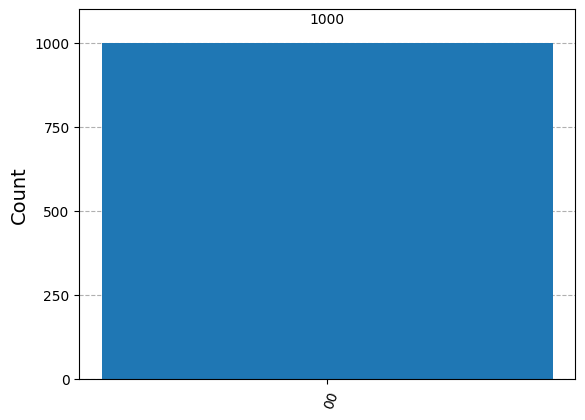

In [19]:
job = backend.run(qc, shots=1000)
job_monitor(job)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

# 2. Bernstein-Vazirani Algorithm

<div style="background-color:rgba(243, 248, 255, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(101, 174, 247, 1.0); color: #000000;">

The Deutsch-Jozsa Algorithm is a clear example of a quantum speedup, albeit for a contrived problem. The rest of our toy algorithms are also somewhat contrived, but they get at the heart of what makes quantum computers powerful -- leveraging superposition and interference effects from phases.

Now consider the following problem. We have a mystery bitstring $s \in \{0,1\}^n$. From this $s$, we can define a function $f: \{0,1\}^n \rightarrow {0,1}$ which performs the dot product modulo 2. In other words:

$$ f(x) = x\cdot s = x_n\cdot s_n \oplus \cdots \oplus x_2\cdot s_2 \oplus x_1\cdot s_1$$

For example, if $s=011$, then:

| $x$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; |  $f(x)$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | 
| :-------------------------------- |  :-------------------------------- |
 |000 | 0 |
 |001| 1 | 
 |010 | 1| 
 |011| 0| 
 |100 | 0 |
 |101| 1 | 
 |110 | 1| 
 |111| 0|

The goal: determine $s$!

Classically, the best approach we have is to go one by one down the binary digits, inputting $2^k$ for $k\in\{0,1,\cdots,n-1\}$. These inputs are the binary strings with exactly one 1 in the kth bit, which would "pick out" the kth bit in $s$ from the dot product. In the above table, you can see how $s$ can be reconstructed from $f(100),f(010),f(001)$. So we would need $n$ queries to determine $s$.

With a quantum algorithm... you guessed it... we only need one query!

<div/>

In [20]:
def BV_oracle(qc,qx,qy,string):

    if len(string) != qx.size():
        raise ValueError(f"The string length ({len(string)}) and register size ({qx.size()}) don't match.")

    # reverse string order to match default ordering
    # then apply gates
    s_inv = string[::-1]
    for i in range (qx.size()):
        if s_inv[i] == '1':
            qc.cx(qx[i],qy[0])

In [24]:
secret_string = '1100'

len_x = len(secret_string)
qx = QuantumRegister(len_x, 'x')
qy = QuantumRegister(1, 'y')
cr = ClassicalRegister(len_x)
qc = QuantumCircuit(qx,qy,cr, name='QSS6.2_BV')

qc.h(qx)
qc.x(qy)
qc.h(qy)

BV_oracle(qc,qx,qy,secret_string)
qc.h(qx)

qc.measure(qx,cr)
qc.draw()

       ┌───┐               ┌───┐┌───┐                
x[0]: ■┤ H ├───────────────┤ H ├┤ M ├─────────────── 
       ├───┤               ├───┤└─╥─┘┌───┐           
x[1]: ■┤ H ├───────────────┤ H ├──║──┤ M ├────────── 
       ├───┤               ├───┤  ║  └─╥─┘┌───┐      
x[2]: ■┤ H ├───────■───────┤ H ├──║────║──┤ M ├───── 
       ├───┤       │       ├───┤  ║    ║  └─╥─┘┌───┐ 
x[3]: ■┤ H ├───────│────■──┤ H ├──║────║────║──┤ M ├ 
       ├───┤┌───┐┌─┴─┐┌─┴─┐└───┘  ║    ║    ║  └─╥─┘ 
y[0]: ■┤ X ├┤ H ├┤ X ├┤ X ├───────║────║────║────║── 
       └───┘└───┘└───┘└───┘       ║    ║    ║    ║   
c: 4/ ■═══════════════════════════╩════╩════╩════╩══ 
                                  0    1    2    3   


Job Running
Job Done.
Ending Job Monitor


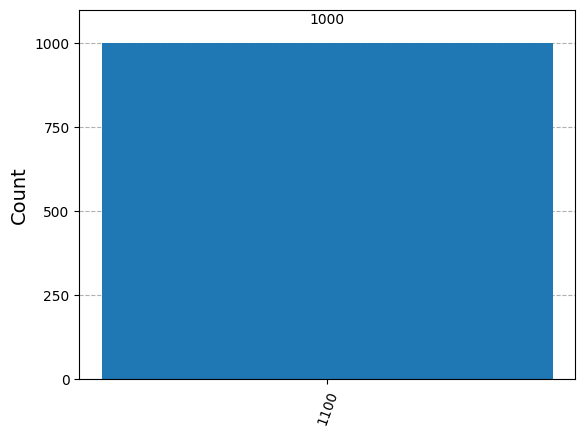

In [25]:
job = backend.run(qc, shots=1000)
job_monitor(job)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

<div style="background-color:rgba(252, 245, 255, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(190, 111, 227, 1.0); color: #000000;">

### Challenge Problem: Probabalistic Bernstein-Vazirani Algorithm

We can extend what we just did above to the case of two secret strings, $s_1$ and $s_2$. In order to accomplish this, we need another auxillary bit to help us out. Follow the steps below to construct the oracle for two hidden strings.

Note that when we measure our qubits, we can only get out one bit string at a time. So it is impossible to determine both $s_1$ and $s_2$ in one query. But we should be able to determine $s_1$ and $s_2$ over the course of a couple shots, since each one should be measured with 50% probability.


<div/>

Here is the skeleton circuit. We have our register for $x$, our qubit $y$, and one extra control qubit which we can label $a$ for auxillary. We prepare the $x$ and $y$ registers as before, and put the $a$ qubit in equal superposition with a Hadamard as well.

In [ ]:
s1 = '101'
s2 = '111'

len_x = len(s1)
qx = QuantumRegister(len_x, 'x')
qy = QuantumRegister(1, 'y')
qa = QuantumRegister(1, 'a')
cr = ClassicalRegister(len_x)
qc = QuantumCircuit(qx,qy,qa,cr)

# equal superposition of all bitstrings
qc.h(qx)

# prepare |-> state on y
qc.x(qy)
qc.h(qy)

# prepare |+> state on a
qc.h(qa)

qc.barrier()
# ORACLE goes here
qc.barrier()

# undo superposition on x
qc.h(qx)

# measure x
qc.measure(qx,cr)
qc.draw()

Now let's build the oracle. We will need to include the oracle for both $s_1$ and $s_2$ like before, BUT we need a way to pick one of those oracles with 50% probability. That way, the problem is reduced to the regular BV algorithm, and therefore each shot we have a 50% chance of measuring $s_1$ and a 50% chance of measuring $s_2$.

We use the auxillary qubit to help us out. We already put it in an equal superposition of 0 and 1. What should you do if you want to apply the oracle for $s_1$ if and only if the auxillary qubit is 1?

*Remember that our oracle is composed of CNOT gates. We can turn all of those CNOTs into Toffoli gates, so now the CNOTs are only applied if the auxillary qubit is 1.*

Now we want to only apply the oracle for $s_2$ if we DID NOT apply the oracle for $s_1$. What gate should you apply to a qubit to flip its behavior as a control qubit?

*We can apply an X gate to the auxillary qubit in between the two oracles, so that it only activates one of them.*

Now we know how to build the oracle. Use the code from the previous section to help you define the oracle.

In [ ]:
def BV_oracle_two_strings(qc,qx,qy,qa,s1,s2):

    ## ORACLE for s1 conditioned on qa
    
    qc.barrier()

    ## FLIP qa
    
    qc.barrier()

    ## ORACLE for s2 conditioned on qa

In [ ]:
s1 = ###
s2 = ###

len_x = len(s1)
qx = QuantumRegister(len_x, 'x')
qy = QuantumRegister(1, 'y')
qa = QuantumRegister(1, 'a')
cr = ClassicalRegister(len_x)
qc = QuantumCircuit(qx,qy,qa,cr)

# equal superposition of all bitstrings
qc.h(qx)

# prepare |-> state on y
qc.x(qy)
qc.h(qy)

# prepare |+> state on a
qc.h(qa)

qc.barrier()

# ORACLE
BV_oracle_two_strings(qc,qx,qy,qa,s1,s2)

qc.barrier()

# undo superposition on x
qc.h(qx)

# measure x
qc.measure(qx,cr)
qc.draw()

In [ ]:
# RUN the circuit to check your work!
job = backend.run(qc, shots=1024)
job_monitor(job)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

# 3. Simon's Algorithm

<div style="background-color:rgba(247, 255, 245, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(0, 153, 51, 1.0); color: #000000;">

Again, we have a secret string $s$. We are given a function $f: \{0,1\}^n \rightarrow \{0,1\}^n$ which satisfies $f(x)=f(y)$ if and only if $x=y$ or $x\oplus s = y$. In other words, $f$ is periodic, i.e. two distinct inputs can only have the same output if they are separated by $s$.

Here is an example for s=011.
| $x$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; |  $f(x)$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | 
| :-------------------------------- |  :-------------------------------- |
 |000 | 000 |
 |001| 001 | 
 |010 | 001| 
 |011| 000| 
 |100 | 010 |
 |101| 111 | 
 |110 | 111| 
 |111| 010|

We can see that $000 \oplus 011 = 011$ and they both have the same output, $001 \oplus 011 = 010$ and they both have the same output, etc. It is also possible for $s$ to be zero, in which case $f$ is a one-to-one function (every distinct input has a distinct output).

Classically, the best approach to find $s$ is to randomly query $f$ until you find two inputs which give the same output. In the worst case, you may have to query half of the inputs to determine that no two inputs share an output. Therefore any classical approach requires $\mathcal{O}(2^{n/2})$ queries.

Using Simon's algorithm, we can do this in $\mathcal{O}(n)$ queries. We need to run the circuit until we determine $n/2$ unique measurement results. Each measurement result $z$ satisfies $s\cdot z = 0$, so if we have $n$ results, we can reconstruct $s$ from the system of $n$ equations. Let's test out Simon's algorithm now!

</div>
$$ $$


In [33]:
def simon_oracle(qc,qx,qy,string):

    if len(string) != qx.size():
        raise ValueError(f"The string length ({len(string)}) and register size ({qx.size()}) don't match.")

    s_inv = string[::-1]
    n = qx.size()

    # copy the x register to the y register
    for i in range(n):
        qc.cx(qx[i],qy[i])
    # apply conditional gates
    first_1_idx = s_inv.find('1')
    for i in range(n):
        if s_inv[i] == '1':
            qc.cx(qx[first_1_idx],qy[i])

In [34]:
string = '101'
len_x = len(string)

qx = QuantumRegister(len_x, 'x')
qy = QuantumRegister(len_x, 'y')
crx = ClassicalRegister(len_x)
qc = QuantumCircuit(qx,qy,crx, name='QSS6.3_Simons')

qc.h(qx)
simon_oracle(qc,qx,qy,string)
qc.h(qx)

qc.measure(qx,crx)
qc.draw()

       ┌───┐                         ┌───┐┌───┐           
x[0]: ■┤ H ├──■──────────────■────■──┤ H ├┤ M ├────────── 
       ├───┤  │              │    │  ├───┤└─╥─┘┌───┐      
x[1]: ■┤ H ├──│────■─────────│────│──┤ H ├──║──┤ M ├───── 
       ├───┤  │    │         │    │  ├───┤  ║  └─╥─┘┌───┐ 
x[2]: ■┤ H ├──│────│────■────│────│──┤ H ├──║────║──┤ M ├ 
       └───┘┌─┴─┐  │    │  ┌─┴─┐  │  └───┘  ║    ║  └─╥─┘ 
y[0]: ■─────┤ X ├──│────│──┤ X ├──│─────────║────║────║── 
            └───┘┌─┴─┐  │  └───┘  │         ║    ║    ║   
y[1]: ■──────────┤ X ├──│─────────│─────────║────║────║── 
                 └───┘┌─┴─┐     ┌─┴─┐       ║    ║    ║   
y[2]: ■───────────────┤ X ├─────┤ X ├───────║────║────║── 
                      └───┘     └───┘       ║    ║    ║   
c: 3/ ■═════════════════════════════════════╩════╩════╩══ 
                                            0    1    2   


Job Running
Job Done.
Ending Job Monitor


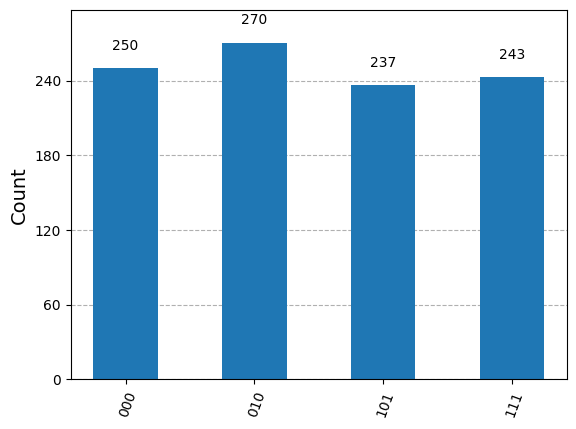

In [35]:
job = backend.run(qc, shots=1000)
job_monitor(job)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

In [36]:
compute_dot_products(string, counts)

101 . 000 = 0 = 0 (mod 2)
101 . 010 = 0 = 0 (mod 2)
101 . 101 = 2 = 0 (mod 2)
101 . 111 = 2 = 0 (mod 2)


<div style="background-color:rgba(252, 245, 255, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(190, 111, 227, 1.0); color: #000000;">

### Challenge Problems: 

**A)** What happens if $s=0$ (as a string '00...0')? Can you still determine $s$? How is this case different from all the others?

**B)** Try Simon's algorithm with more qubits! How many queries do you need to find n distinct measurement results? Does it match what you expect?

<div/>

In [ ]:
## your code here